In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

wine = load_wine()
X_wine, y_wine = wine.data, wine.target

In [2]:
FRACTION = 33
X_train_usps = np.genfromtxt('zip.train', delimiter=' ')[::FRACTION]
X_test_usps = np.genfromtxt('zip.test', delimiter=' ')[::FRACTION]

y_train_usps = X_train_usps[:, 0]
y_test_usps = X_test_usps[:, 0]
X_train_usps = X_train_usps[:, 1:]
X_test_usps = X_test_usps[:, 1:]

X_usps = np.concatenate((X_train_usps, X_test_usps), axis=0)
y_usps = np.concatenate((y_train_usps, y_test_usps), axis=0)

In [3]:
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, random_state=2909)
X_train_usps, X_test_usps, y_train_usps, y_test_usps = train_test_split(X_usps, y_usps, random_state=2909)


In [4]:
CV = 5
svm = SVC(probability=True)
scores_wine = cross_val_score(svm, X_train_wine, y_train_wine, cv=CV)
generalization_accuracy_wine = np.mean(scores_wine)

scores_usps = cross_val_score(svm, X_train_usps, y_train_usps, cv=CV)
generalization_accuracy_usps = np.mean(scores_usps)


In [5]:
param_grid = {'SVC__C': [0.01, 0.1, 1, 10], 'SVC__gamma': [0.001, 0.01, 0.1, 1]}
n_jobs = -1  # Use all available CPU cores

scalers = {'StandardScaler': StandardScaler(),
           'MinMaxScaler': MinMaxScaler(),
           'Normalizer': Normalizer(),
           'RobustScaler': RobustScaler()}

best_estimators_wine = {}
best_estimators_usps = {}


In [6]:
for scaler_name, scaler in scalers.items():
    wine_pipeline = Pipeline([('scaler', scaler), ('SVC', SVC(probability=True))])
    wine_grid_search = GridSearchCV(wine_pipeline, param_grid, cv=CV, n_jobs=n_jobs)
    wine_grid_search.fit(X_train_wine, y_train_wine)

    best_estimators_wine[scaler_name] = wine_grid_search.best_estimator_

    wine_best_score = wine_grid_search.best_score_
    wine_test_score = wine_grid_search.score(X_test_wine, y_test_wine)
    wine_best_params = wine_grid_search.best_params_
    wine_test_error_rate = 1 - wine_test_score

    print(f"Wine - {scaler_name}: Best CV Accuracy: {wine_best_score}, Test Set Accuracy: {wine_test_score}, Best Params: {wine_best_params}, Test Error Rate: {wine_test_error_rate}")


Wine - StandardScaler: Best CV Accuracy: 0.9925925925925926, Test Set Accuracy: 1.0, Best Params: {'SVC__C': 1, 'SVC__gamma': 0.01}, Test Error Rate: 0.0
Wine - MinMaxScaler: Best CV Accuracy: 0.9851851851851852, Test Set Accuracy: 0.9777777777777777, Best Params: {'SVC__C': 0.1, 'SVC__gamma': 1}, Test Error Rate: 0.022222222222222254
Wine - Normalizer: Best CV Accuracy: 0.6168091168091168, Test Set Accuracy: 0.6888888888888889, Best Params: {'SVC__C': 10, 'SVC__gamma': 1}, Test Error Rate: 0.3111111111111111
Wine - RobustScaler: Best CV Accuracy: 0.9849002849002849, Test Set Accuracy: 0.9777777777777777, Best Params: {'SVC__C': 1, 'SVC__gamma': 0.1}, Test Error Rate: 0.022222222222222254


In [7]:
for scaler_name, scaler in scalers.items():
    usps_pipeline = Pipeline([('scaler', scaler), ('SVC', SVC(probability=True))])
    usps_grid_search = GridSearchCV(usps_pipeline, param_grid, cv=CV, n_jobs=n_jobs)
    usps_grid_search.fit(X_train_usps, y_train_usps)

    best_estimators_usps[scaler_name] = usps_grid_search.best_estimator_

    usps_best_score = usps_grid_search.best_score_
    usps_test_score = usps_grid_search.score(X_test_usps, y_test_usps)
    usps_best_params = usps_grid_search.best_params_
    usps_test_error_rate = 1 - usps_test_score

    print(f"USPS - {scaler_name}: Best CV Accuracy: {usps_best_score}, Test Set Accuracy: {usps_test_score}, Best Params: {usps_best_params}, Test Error Rate: {usps_test_error_rate}")


USPS - StandardScaler: Best CV Accuracy: 0.7960132890365449, Test Set Accuracy: 0.9436619718309859, Best Params: {'SVC__C': 10, 'SVC__gamma': 0.001}, Test Error Rate: 0.05633802816901412
USPS - MinMaxScaler: Best CV Accuracy: 0.8197120708748615, Test Set Accuracy: 0.9295774647887324, Best Params: {'SVC__C': 10, 'SVC__gamma': 0.01}, Test Error Rate: 0.07042253521126762
USPS - Normalizer: Best CV Accuracy: 0.8198228128460686, Test Set Accuracy: 0.9295774647887324, Best Params: {'SVC__C': 10, 'SVC__gamma': 0.1}, Test Error Rate: 0.07042253521126762
USPS - RobustScaler: Best CV Accuracy: 0.5118493909191584, Test Set Accuracy: 0.4507042253521127, Best Params: {'SVC__C': 10, 'SVC__gamma': 0.001}, Test Error Rate: 0.5492957746478873


In [8]:
# Selecting the best model for the wine dataset
best_model_wine = best_estimators_wine[max(best_estimators_wine, key=lambda k: best_estimators_wine[k].score(X_test_wine, y_test_wine))]

# Selecting the best model for the USPS dataset
best_model_usps = best_estimators_usps[max(best_estimators_usps, key=lambda k: best_estimators_usps[k].score(X_test_usps, y_test_usps))]


In [9]:
def compute_conformity_scores(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)
    # Conformity score is the probability of the correct label
    conformity_scores = y_proba[np.arange(y_test.shape[0]), y_test.astype(int)]
    return conformity_scores


In [10]:
def cross_conformal_predictor(model, X, y, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=2909)

    # Initialize p_values to None, will be set after fitting the model
    p_values = None

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model and then create the p_values array
        model.fit(X_train, y_train)
        if p_values is None:
            # Now model.classes_ is available and can be used
            p_values = np.zeros((len(y), len(model.classes_)))

        # Rest of your existing code to calculate p-values
        conformity_scores = compute_conformity_scores(model, X_train, y_train, X_test, y_test)
        for i, test_sample in enumerate(X_test):
            for label in range(len(model.classes_)):  # Use len(model.classes_)
                if label == y_test[i]:
                    continue
                # Assign p-value for each label
                p_values[test_index[i], label] = np.mean(conformity_scores <= conformity_scores[i])

    return p_values


In [11]:
# For the wine dataset
p_values_wine = cross_conformal_predictor(best_model_wine, X_train_wine, y_train_wine)

# For the USPS dataset
p_values_usps = cross_conformal_predictor(best_model_usps, X_train_usps, y_train_usps)


In [12]:
def generate_prediction_sets(p_values, epsilon):
    """
    Generate prediction sets for each test sample based on p-values and significance level epsilon.
    """
    prediction_sets = (p_values > epsilon)
    return prediction_sets

In [13]:
def compute_error_rate(prediction_sets, y_test):
    """
    Compute the error rate based on the prediction sets and true labels.
    """
    errors = np.sum(np.logical_not(prediction_sets[np.arange(len(y_test)), y_test.astype(int)]))
    error_rate = errors / len(y_test)
    return error_rate

In [14]:
def plot_calibration_curve(y_test, p_values, steps=100):
    """
    Plot the calibration curve (error rate vs epsilon) and add an ideal line.
    """
    epsilons = np.linspace(0, 1, steps)
    error_rates = []

    for epsilon in epsilons:
        prediction_sets = generate_prediction_sets(p_values, epsilon)
        error_rate = compute_error_rate(prediction_sets, y_test)
        error_rates.append(error_rate)

    plt.plot(epsilons, error_rates, label="Calibration Curve")
    plt.plot(epsilons, epsilons, 'k--', label="Ideal Line")  # Ideal line
    plt.xlabel("Significance Level (ε)")
    plt.ylabel("Error Rate")
    plt.title("Calibration Curve with Ideal Line")
    plt.legend()
    plt.show()

In [15]:
def compute_average_false_p_value(y_test, p_values):
    """
    Compute the average false p-value on the test set.
    """
    false_p_values = p_values.copy()
    false_p_values[np.arange(len(y_test)), y_test.astype(int)] = np.nan  # Ignore true labels
    average_false_p_value = np.nanmean(false_p_values)
    return average_false_p_value

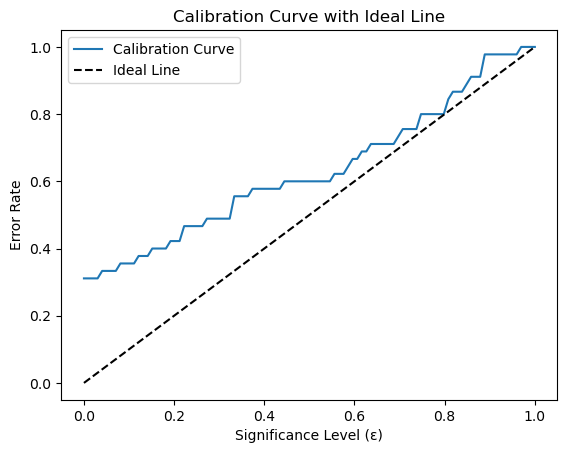

Average False P-Value for Wine Dataset: 0.3426891689603554


In [16]:
plot_calibration_curve(y_test_wine, p_values_wine)  # For wine dataset

avg_false_p_val_wine = compute_average_false_p_value(y_test_wine, p_values_wine)


print("Average False P-Value for Wine Dataset:", avg_false_p_val_wine)



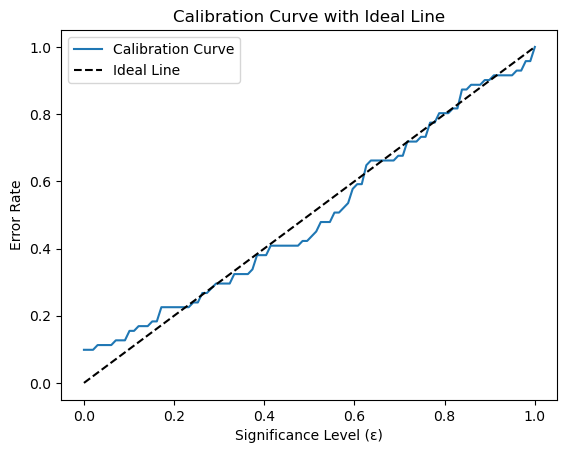

Average False P-Value for USPS Dataset: 0.45915962105498703


In [17]:
plot_calibration_curve(y_test_usps, p_values_usps)  # For USPS dataset
avg_false_p_val_usps = compute_average_false_p_value(y_test_usps, p_values_usps)
print("Average False P-Value for USPS Dataset:", avg_false_p_val_usps)